# Recommender System based on collaborative Filtering algorithm on movies dataset.

## Collaborative filtering

Recommendation engines use item and user-based similarity measures to examine a user's historical preferences to make recommendations for new "things" the user might be interested in.  In this notebook i've implemented a particular recommendation system algorithm called collaborative filtering and apply it to a data set of movie ratings.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from scipy.io import loadmat
%matplotlib inline


In [3]:
data = loadmat('data/movies.mat')
data

{'R': array([[1, 1, 0, ..., 1, 0, 0],
        [1, 0, 0, ..., 0, 0, 1],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'Y': array([[5, 4, 0, ..., 5, 0, 0],
        [3, 0, 0, ..., 0, 0, 5],
        [4, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 '__globals__': [],
 '__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Thu Dec  1 17:19:26 2011',
 '__version__': '1.0'}

Y is a (number of movies x number of users) array containing ratings from 1 to 5.  R is an "indicator" array containing binary values indicating if a user has rated a movie or not.  Both should have the same shape.

In [4]:
Y = data['Y']
R = data['R']
Y.shape, R.shape

((1682, 943), (1682, 943))

We can look at the average rating for a movie by averaging over a row in Y for indexes where a rating is present.

In [5]:
Y[1,np.where(R[1,:]==1)[0]].mean()

3.2061068702290076

We can also try to "visualize" the data by rendering the matrix as if it were an image.  We can't glean too much from this but it does give us an idea of a relative density of ratings across users and movies.

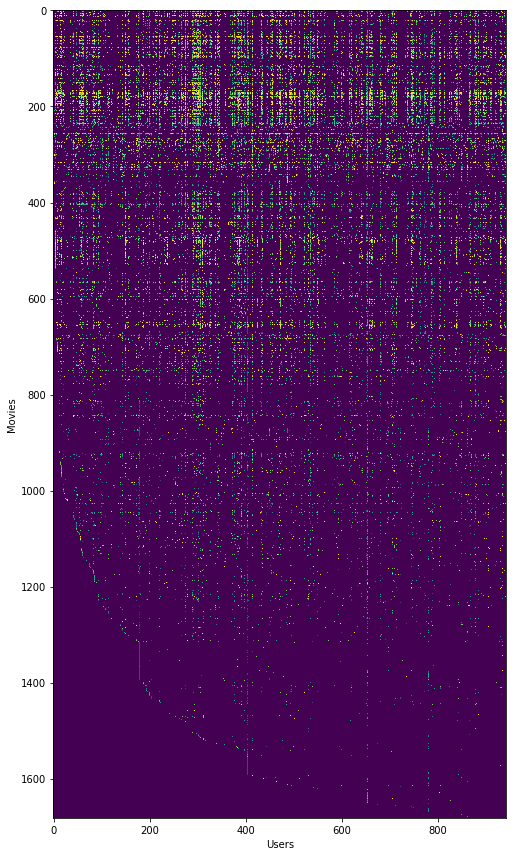

In [6]:
fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(Y)
ax.set_xlabel('Users')
ax.set_ylabel('Movies')
fig.tight_layout()

Next I'm going to implement a cost function for collaborative filtering.  Intuitively, the "cost" is the degree to which a set of movie rating predictions deviate from the true predictions.  The cost equation is given in the exercise text.  It is based on two sets of parameter matrices called X and Theta in the text.  These are "unrolled" into the "params" input so that we can use SciPy's optimization package later on.  Note that I've included the array/matrix shapes in comments to help illustrate how the matrix interactions work.

In [7]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    return J

In order to test this, we're provided with a set of pre-trained parameters that we can evaluate.  To keep the evaluation time down, we'll look at just a small sub-set of the data.

In [8]:
params_data = loadmat('data/movieParams.mat')
X = params_data['X']
Theta = params_data['Theta']
X.shape, Theta.shape

((1682, 10), (943, 10))

In [9]:
users = 4
movies = 5
features = 3

X_sub = X[:movies, :features]
Theta_sub = Theta[:users, :features]
Y_sub = Y[:movies, :users]
R_sub = R[:movies, :users]

params = np.concatenate((np.ravel(X_sub), np.ravel(Theta_sub)))

cost(params, Y_sub, R_sub, features)

22.224603725685675

Great, this matches what the exercise text said we're supposed to get.  Next we need to implement the gradient computations.  Just like we did with the neural networks implementation in exercise 4, we'll extend the cost function to also compute the gradients.

In [10]:
def cost(params, Y, R, num_features):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # calculate the gradients
    X_grad = error * Theta
    Theta_grad = error.T * X
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [35]:
J, grad = cost(params, Y_sub, R_sub, features)
J, grad

(22.224603725685675,
 array([ -2.52899165,   7.57570308,  -1.89979026,  -0.56819597,
          3.35265031,  -0.52339845,  -0.83240713,   4.91163297,
         -0.76677878,  -0.38358278,   2.26333698,  -0.35334048,
         -0.80378006,   4.74271842,  -0.74040871, -10.5680202 ,
          4.62776019,  -7.16004443,  -3.05099006,   1.16441367,
         -3.47410789,   0.        ,   0.        ,   0.        ,
          0.        ,   0.        ,   0.        ]))

Our next step is to add regularization to both the cost and gradient calculations.  We'll create one final regularized version of the function (note that this version includes an additional "learning rate" parameter, called "lambda" in the text).

In [36]:
def cost(params, Y, R, num_features, learning_rate):
    Y = np.matrix(Y)  # (1682, 943)
    R = np.matrix(R)  # (1682, 943)
    num_movies = Y.shape[0]
    num_users = Y.shape[1]
    
    # reshape the parameter array into parameter matrices
    X = np.matrix(np.reshape(params[:num_movies * num_features], (num_movies, num_features)))  # (1682, 10)
    Theta = np.matrix(np.reshape(params[num_movies * num_features:], (num_users, num_features)))  # (943, 10)
    
    # initializations
    J = 0
    X_grad = np.zeros(X.shape)  # (1682, 10)
    Theta_grad = np.zeros(Theta.shape)  # (943, 10)
    
    # compute the cost
    error = np.multiply((X * Theta.T) - Y, R)  # (1682, 943)
    squared_error = np.power(error, 2)  # (1682, 943)
    J = (1. / 2) * np.sum(squared_error)
    
    # add the cost regularization
    J = J + ((learning_rate / 2) * np.sum(np.power(Theta, 2)))
    J = J + ((learning_rate / 2) * np.sum(np.power(X, 2)))
    
    # calculate the gradients with regularization
    X_grad = (error * Theta) + (learning_rate * X)
    Theta_grad = (error.T * X) + (learning_rate * Theta)
    
    # unravel the gradient matrices into a single array
    grad = np.concatenate((np.ravel(X_grad), np.ravel(Theta_grad)))
    
    return J, grad

In [37]:
J, grad = cost(params, Y_sub, R_sub, features, 1.5)
J, grad

(31.34405624427422,
 array([ -0.95596339,   6.97535514,  -0.10861109,   0.60308088,
          2.77421145,   0.25839822,   0.12985616,   4.0898522 ,
         -0.89247334,   0.29684395,   1.06300933,   0.66738144,
          0.60252677,   4.90185327,  -0.19747928, -10.13985478,
          2.10136256,  -6.76563628,  -2.29347024,   0.48244098,
         -2.99791422,  -0.64787484,  -0.71820673,   1.27006666,
          1.09289758,  -0.40784086,   0.49026541]))

This result again matches up with the expected output from the exercise code, so it looks like the regularization is working.  Before we train the model, we have one final step.  We're tasked with creating our own movie ratings so we can use the model to generate personalized recommendations.  A file is provided for us that links the movie index to its title.  Let's load the file into a dictionary.

In [38]:
movie_idx = {}
f = open('data/movie_ids.txt')
for line in f:
    tokens = line.split(' ')
    tokens[-1] = tokens[-1][:-1]
    movie_idx[int(tokens[0]) - 1] = ' '.join(tokens[1:])

In [39]:
movie_idx[0]

'Toy Story (1995)'

We'll use the ratings provided in the exercise.

In [40]:
ratings = np.zeros((1682, 1))

ratings[0] = 4
ratings[6] = 3
ratings[11] = 5
ratings[53] = 4
ratings[63] = 5
ratings[65] = 3
ratings[68] = 5
ratings[97] = 2
ratings[182] = 4
ratings[225] = 5
ratings[354] = 5

print('Rated {0} with {1} stars.'.format(movie_idx[0], str(int(ratings[0]))))
print('Rated {0} with {1} stars.'.format(movie_idx[6], str(int(ratings[6]))))
print('Rated {0} with {1} stars.'.format(movie_idx[11], str(int(ratings[11]))))
print('Rated {0} with {1} stars.'.format(movie_idx[53], str(int(ratings[53]))))
print('Rated {0} with {1} stars.'.format(movie_idx[63], str(int(ratings[63]))))
print('Rated {0} with {1} stars.'.format(movie_idx[65], str(int(ratings[65]))))
print('Rated {0} with {1} stars.'.format(movie_idx[68], str(int(ratings[68]))))
print('Rated {0} with {1} stars.'.format(movie_idx[97], str(int(ratings[97]))))
print('Rated {0} with {1} stars.'.format(movie_idx[182], str(int(ratings[182]))))
print('Rated {0} with {1} stars.'.format(movie_idx[225], str(int(ratings[225]))))
print('Rated {0} with {1} stars.'.format(movie_idx[354], str(int(ratings[354]))))

Rated Toy Story (1995) with 4 stars.
Rated Twelve Monkeys (1995) with 3 stars.
Rated Usual Suspects, The (1995) with 5 stars.
Rated Outbreak (1995) with 4 stars.
Rated Shawshank Redemption, The (1994) with 5 stars.
Rated While You Were Sleeping (1995) with 3 stars.
Rated Forrest Gump (1994) with 5 stars.
Rated Silence of the Lambs, The (1991) with 2 stars.
Rated Alien (1979) with 4 stars.
Rated Die Hard 2 (1990) with 5 stars.
Rated Sphere (1998) with 5 stars.


We can add our own ratings vector to the existing data set to include in the model.

In [42]:
R = data['R']
Y = data['Y']

Y = np.append(Y, ratings, axis=1)
R = np.append(R, ratings != 0, axis=1)

Y.shape, R.shape, ratings.shape

((1682, 944), (1682, 944), (1682, 1))

We're not just about ready to train the collaborative filtering model.  We just need to define some variables and normalize the ratings.

In [43]:
movies = Y.shape[0]  # 1682
users = Y.shape[1]  # 944
features = 10
learning_rate = 10.

X = np.random.random(size=(movies, features))
Theta = np.random.random(size=(users, features))
params = np.concatenate((np.ravel(X), np.ravel(Theta)))

X.shape, Theta.shape, params.shape

((1682, 10), (944, 10), (26260,))

In [46]:
Ymean = np.zeros((movies, 1))
Ynorm = np.zeros((movies, users))

for i in range(movies):
    idx = np.where(R[i,:] == 1)[0]
    Ymean[i] = Y[i,idx].mean()
    Ynorm[i,idx] = Y[i,idx] - Ymean[i]

Ynorm.mean()

5.507036456515984e-19

In [47]:
from scipy.optimize import minimize

fmin = minimize(fun=cost, x0=params, args=(Ynorm, R, features, learning_rate), 
                method='CG', jac=True, options={'maxiter': 100})
fmin

     fun: 38959.72958318608
     jac: array([ 0.00011678, -0.02856398,  0.07154246, ...,  0.00035716,
        0.00153681, -0.00032505])
 message: 'Maximum number of iterations has been exceeded.'
    nfev: 147
     nit: 100
    njev: 147
  status: 1
 success: False
       x: array([-0.45899311,  0.85315147, -0.27034926, ...,  0.08487653,
        0.0412157 , -0.19251456])

In [48]:
X = np.matrix(np.reshape(fmin.x[:movies * features], (movies, features)))
Theta = np.matrix(np.reshape(fmin.x[movies * features:], (users, features)))

X.shape, Theta.shape

((1682, 10), (944, 10))

Our trained parameters are now in X and Theta.  We can use these to create some recommendations for the user we added.

In [49]:
predictions = X * Theta.T 
my_preds = predictions[:, -1] + Ymean
my_preds.shape

(1682, 1)

In [50]:
sorted_preds = np.sort(my_preds, axis=0)[::-1]
sorted_preds[:10]

matrix([[5.0000032 ],
        [5.00000268],
        [5.00000218],
        [5.00000182],
        [5.00000149],
        [5.000001  ],
        [5.00000058],
        [5.00000007],
        [4.99999895],
        [4.99999691]])

That gives us an ordered list of the top ratings, but we lost what index those ratings are for.  We actually need to use argsort so we know what movie the predicted rating corresponds to.

In [51]:
idx = np.argsort(my_preds, axis=0)[::-1]
idx

matrix([[1200],
        [ 813],
        [1121],
        ...,
        [1431],
        [1358],
        [1333]], dtype=int64)

In [52]:
print("Top 10 movie predictions:")
for i in range(10):
    j = int(idx[i])
    print('Predicted rating of {0} for movie {1}.'.format(str(float(my_preds[j])), movie_idx[j]))

Top 10 movie predictions:
Predicted rating of 5.00000319705467 for movie Marlene Dietrich: Shadow and Light (1996) .
Predicted rating of 5.000002684508499 for movie Great Day in Harlem, A (1994).
Predicted rating of 5.0000021783773825 for movie They Made Me a Criminal (1939).
Predicted rating of 5.000001823350216 for movie Someone Else's America (1995).
Predicted rating of 5.000001492525876 for movie Entertaining Angels: The Dorothy Day Story (1996).
Predicted rating of 5.000000997073871 for movie Saint of Fort Washington, The (1993).
Predicted rating of 5.000000580497528 for movie Santa with Muscles (1996).
Predicted rating of 5.000000066755787 for movie Aiqing wansui (1994).
Predicted rating of 4.999998948226962 for movie Star Kid (1997).
Predicted rating of 4.999996914964201 for movie Prefontaine (1997).


The recommended movies don't actually line up that well with what's in the exercise text.  The reason why isn't too clear and I haven't found anything to account for it.  If you spot a mistake somewhere, please let me know.  Even if there's some minor difference or a step in the original exercise that I missed, the bulk of the example is accurate.

That concludes the exercise and this notebook series!  I hope you learned as much as I did.  Thanks for reading.